# Cコード分類
5つのOSS内C(C++)コード分類タスク

In [1]:
Repos = [
    ["FFmpeg", "https://github.com/FFmpeg/FFmpeg.git"],
    ["fftw3", "https://github.com/FFTW/fftw3.git"],
    ["sakura", "https://github.com/sakura-editor/sakura.git"],
    ["x264", "https://github.com/mirror/x264.git"],
    ["zlib", "https://github.com/madler/zlib.git"],
]

Repo_Names = [r[0] for r in Repos]

def clone_repos():
    import subprocess
    for repo in Repos:
        cmd = f"git clone {repo[1]} data/{repo[0]}"
        p = subprocess.run([cmd], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(p.stdout("utf8"))

# clone_repos()

In [2]:
import glob
import os
import random
import numpy as np
import re

from gensim import models
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn import svm, metrics

from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [3]:
def c_files_path():
    target_file_name = ["*.c", "*.cpp"]
    files = []
    for filename in target_file_name:
        search_path = os.path.join("data", "**", filename)
        files.extend(glob.glob(search_path, recursive=True))
    return files

def get_project(file):
    splitted = file.split(os.sep)
    return splitted[1]

def normalize_text(text):
    # "/* ~ */"コメントの削除
    texts = re.split('[/\*|\*/]', text)
    texts = [text for text in texts if len(text)>0]
    text = "".join(texts[0::2])
    # "// ~"コメントの削除
    text = re.sub("//.*\n", "", text)
    # 改行、タブの空白スペース化
    text = text.replace("\n", " ").replace("\t", " ")
    return text

def read_doc(path):
    encodings = ["utf8", "ansi", "ascii"]
    for encode in encodings:
        try:
            with open(path, encoding=encode) as f:
                doc = f.read()
                return normalize_text(doc)
        except:
            continue
    print(f"decode error in {path}")
    return "decode error"

def token_to_sentence(token, name):
    return TaggedDocument(words=token, tags=[name])

def corpus_to_sentences(texts, p_index):
    for idx, (doc, p_index) in enumerate(zip(texts, p_index)):
        yield token_to_sentence(texts, Repo_Names[p_index])

In [4]:
# データ作成
c_files = c_files_path()
random.shuffle(c_files)
texts = []
p_indexs = []
for c_file in c_files:
    text = read_doc(c_file)
    p_name = get_project(c_file)
    p_index = Repo_Names.index(p_name)

    texts.append(text)
    p_indexs.append(p_index)

decode error in data\fftw3\libbench2\verify-r2r.c
decode error in data\fftw3\libbench2\verify-lib.c


In [5]:
# train
def train():
    data =  [sentence for sentence in corpus_to_sentences(texts, p_indexs)]
    model = models.Doc2Vec(data, vector_size=100,
                            alpha=0.0025,
                            min_alpha=0.000001,
                            window=15, min_count=1)
    model.save("d2v_cfile.model")

train()

In [6]:
# classify
model = models.Doc2Vec.load('d2v_cfile.model')
docvecs = [model.infer_vector(text.split(" ")) for text in texts]
p_indexs = [[index] for index in p_indexs]
x_train, x_test, y_train, y_test = train_test_split(docvecs, p_indexs)
clf = svm.LinearSVC(loss='hinge', C=1.0,class_weight='balanced', random_state=0)
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)
ac = metrics.accuracy_score(y_test, y_predict)
cm = metrics.confusion_matrix(y_test, y_predict)
print(f"accuracy = {ac}")
print("confusion matrix")
print(cm)


E:\Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
accuracy = 0.6632064590542099
confusion matrix
[[573  12   3  28  52]
 [ 69   2   0   1   5]
 [ 86   0   0   2   4]
 [ 19   0   0   0   0]
 [ 11   0   0   0   0]]
E:\Programs\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3467 samples in 0.025s...
[t-SNE] Computed neighbors for 3467 samples in 1.986s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3467
[t-SNE] Computed conditional probabilities for sample 2000 / 3467
[t-SNE] Computed conditional probabilities for sample 3000 / 3467
[t-SNE] Computed conditional probabilities for sample 3467 / 3467
[t-SNE] Mean sigma: 0.007161
[t-SNE] Computed conditional probabilities in 0.285s
[t-SNE] Iteration 50: error = 85.1328659, gradient norm = 0.0791815 (50 iterations in 3.580s)
[t-SNE] Iteration 100: error = 85.5980453, gradient norm = 0.0733393 (50 iterations in 4.638s)
[t-SNE] Iteration 150: error = 85.3571548, gradient norm = 0.0755680 (50 iterations in 4.301s)
[t-SNE] Iteration 200: error = 84.5831299, gradient norm = 0.1112413 (50 iterations in 2.992s)
[t-SNE] Iteration 250: error = 85.0842056, gradient norm = 0.0956998 (50 iterations in 3.808s)
[t-SNE] KL divergence after 250 iterati

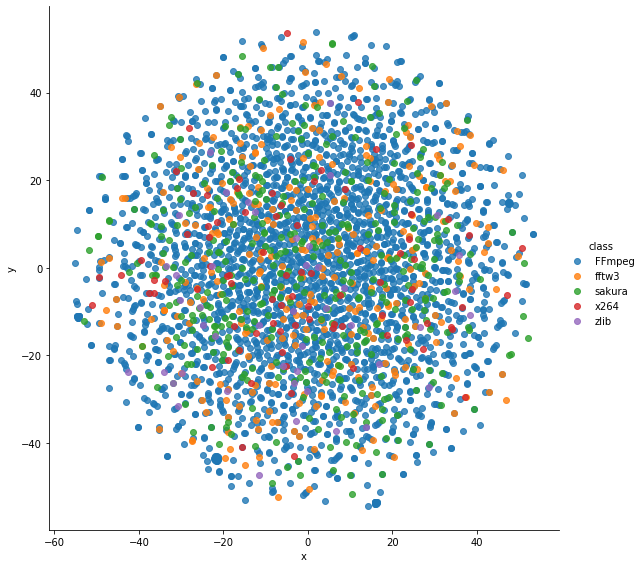

In [7]:
# 可視化
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

tsne_model = TSNE(n_components=2, random_state=0, verbose=2)
tsne_model.fit(docvecs)
df = pd.DataFrame(tsne_model.embedding_[:, 0], columns=['x'])
df['y'] = pd.DataFrame(tsne_model.embedding_[:, 1])
df['class'] = [Repo_Names[p_index[0]] for p_index in p_indexs]
sns.lmplot(data=df, x='x', y='y', hue='class', fit_reg=False, height=8)